<a href="https://colab.research.google.com/github/indrochoco/NYC-Taxi-prediction/blob/main/Copy_2_of_NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path= '/content/drive/MyDrive/almabetter/Copy of NYC Taxi Data.csv'
taxi_data= pd.read_csv(path)

In [4]:
taxi_data.head(6)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443


In [5]:
taxi_data.shape

(1458644, 11)

In [6]:
taxi_data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [7]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [8]:
taxi_data[taxi_data.duplicated() == True]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration


In [9]:
taxi_data.store_and_fwd_flag.unique()

array(['N', 'Y'], dtype=object)

In [10]:
taxi_data.passenger_count.unique()

array([1, 6, 4, 2, 3, 5, 0, 7, 9, 8])

In [11]:
taxi_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [12]:
taxi_data['dropoff_datetime']= pd.to_datetime(taxi_data['dropoff_datetime'])
taxi_data['pickup_datetime']= pd.to_datetime(taxi_data['pickup_datetime'])

In [13]:
value= {'store_and_fwd_flag':{'N':0,'Y':1}}
taxi_data= taxi_data.replace(value)

In [14]:
taxi_data[taxi_data.dropoff_longitude==0]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration


In [15]:
import geopy.distance

In [16]:
#def calculate_distance(df):
dist_list= []
for k in range(taxi_data.shape[0]):

    # Point one
    lat1 = taxi_data.pickup_latitude[k]
    lon1 = taxi_data.pickup_longitude[k]

    # Point two
    lat2 = taxi_data.dropoff_latitude[k]
    lon2 = taxi_data.dropoff_longitude[k]

    # calculate distance between two points
    coords_1 = (lat1,lon1)
    coords_2 = (lat2,lon2)
    distance= geopy.distance.vincenty(coords_1, coords_2).km  # gives distance
    dist_list.append(distance)

# adding distance column to the dataset 
taxi_data['distance']= dist_list

In [17]:
taxi_data['distance']

0          1.502172
1          1.808660
2          6.379687
3          1.483632
4          1.187038
             ...   
1458639    1.227090
1458640    6.046212
1458641    7.821532
1458642    1.092524
1458643    1.133655
Name: distance, Length: 1458644, dtype: float64

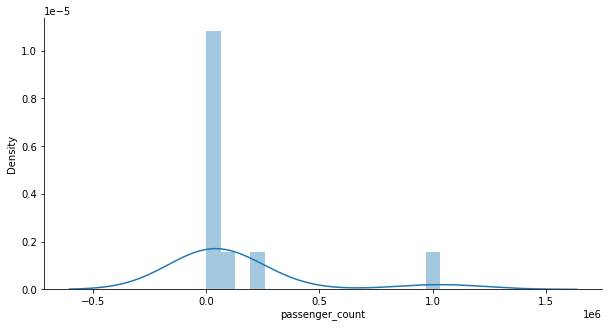

In [18]:
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)
sns.distplot(
    taxi_data['passenger_count'].value_counts()
    )

In [19]:
taxi_data['passenger_count'].value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

In [20]:
import datetime
taxi_data['pickup_year'] = taxi_data['pickup_datetime'].dt.year
taxi_data['pickup_month'] = taxi_data['pickup_datetime'].dt.month
taxi_data['pickup_date'] = taxi_data['pickup_datetime'].dt.day
taxi_data['pickup_hour'] = taxi_data['pickup_datetime'].dt.hour
taxi_data['pickup_minute'] = taxi_data['pickup_datetime'].dt.minute
taxi_data['pickup_second'] = taxi_data['pickup_datetime'].dt.second
taxi_data['pickup_day'] = taxi_data['pickup_datetime'].dt.day_name()

Number of Trips count by week days

Text(0.5, 1.0, 'Number of trips in week days')

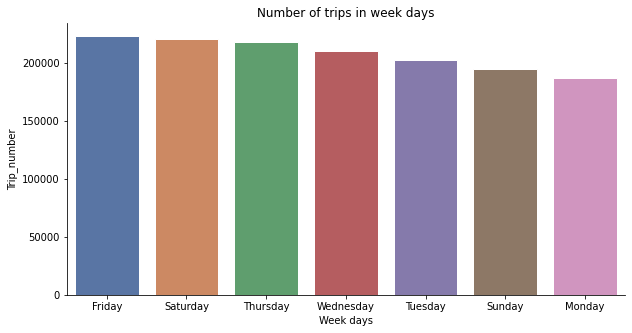

In [21]:
weekdays_number= taxi_data.pickup_day.value_counts().reset_index()
# Plotting graph
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)
sns.set_theme(style="whitegrid")
ax= sns.barplot(x='index',y='pickup_day',data=weekdays_number )
ax.set_ylabel("Trip_number")
ax.set_xlabel("Week days")
plt.title("Number of trips in week days")

Avg duration of trips by week days

In [22]:
avg_duration_day= taxi_data.groupby(['pickup_day'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'}).sort_values(by = "avg_trip_duration" , ascending=False ,ignore_index=True)

In [23]:
avg_duration_day

,pickup_day,avg_trip_duration
0,Thursday,1006.528654
1,Friday,990.224200
2,Tuesday,983.463124
3,Wednesday,975.450494
4,Saturday,948.051175
5,Sunday,901.639395
6,Monday,897.947839


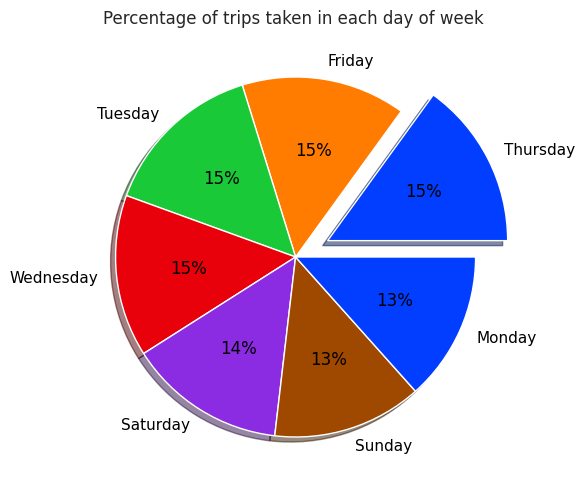

In [24]:
fig_1 = plt.figure(figsize=(8,5),dpi=100)
axes_1 = fig_1.add_axes([0.1,0.1,0.9,0.9])

explode = [0]*7
explode[0] = 0.2
colors = sns.color_palette('bright')[0:6]
z= avg_duration_day['pickup_day'].to_list()
plt.rcParams['text.color'] = 'black'
plt.pie(x=avg_duration_day['avg_trip_duration'],explode=explode,labels=z,labeldistance=1.1,colors=colors,shadow=True,textprops=dict(color="black"),autopct='%1.0f%%')
plt.title("Percentage of trips taken in each day of week ")
plt.show()

we will use number of to replace these days.

In [25]:
# one Hot encoding
encode_day= {'pickup_day':{'Monday':1,'Tuesday':2,'Wednesday':3,'Tuesday':4,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7},}
# replacing the date name with number
taxi_data=taxi_data.replace(encode_day)

Text(0.5, 1.0, 'Pickup Hours Distribution')

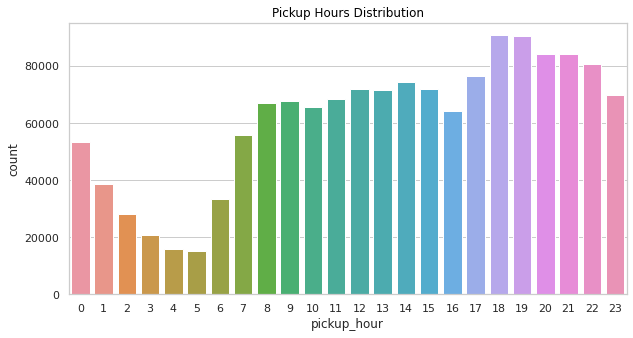

In [26]:
plt.figure(figsize=(10,5))
ax=sns.countplot(x=taxi_data['pickup_hour'])
ax.set_title("Pickup Hours Distribution")

In [27]:
taxi_data['avg_speed(km/hr)']= round((((taxi_data['distance']*1000)/taxi_data['trip_duration'])*3600)/1000,2)

In [28]:
taxi_data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance', 'pickup_year', 'pickup_month',
       'pickup_date', 'pickup_hour', 'pickup_minute', 'pickup_second',
       'pickup_day', 'avg_speed(km/hr)'],
      dtype='object')

In [29]:
taxi_data[taxi_data['avg_speed(km/hr)']>180]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,pickup_year,pickup_month,pickup_date,pickup_hour,pickup_minute,pickup_second,pickup_day,avg_speed(km/hr)
1107,id0729156,2,2016-06-23 13:36:48,2016-06-23 13:36:50,3,-73.827660,40.716175,-73.822113,40.711452,0,2,0.703342,2016,6,23,13,36,48,4,1266.01
107171,id1656254,2,2016-01-18 00:35:38,2016-01-18 00:35:54,1,-73.805527,40.651360,-73.804230,40.661629,0,16,1.145626,2016,1,18,0,35,38,1,257.77
133641,id2362780,2,2016-06-30 05:01:03,2016-06-30 05:01:11,1,-74.164268,40.711639,-74.179352,40.711342,0,8,1.274983,2016,6,30,5,1,3,4,573.74
171801,id1733307,2,2016-06-26 18:02:38,2016-06-26 18:02:50,1,-73.792725,40.656902,-73.788948,40.647270,0,12,1.116290,2016,6,26,18,2,38,7,334.89
176589,id1724402,1,2016-05-17 06:34:59,2016-05-17 06:36:27,1,-73.969231,40.798122,-73.999260,40.753773,0,88,5.539157,2016,5,17,6,34,59,4,226.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1328401,id1644758,2,2016-01-03 14:41:12,2016-01-03 14:44:19,1,-73.999992,40.689610,-73.965492,40.806030,0,187,13.252680,2016,1,3,14,41,12,7,255.13
1359910,id3628988,1,2016-05-05 18:21:37,2016-05-05 18:30:45,1,-79.569733,41.586273,-80.355431,42.090183,0,548,85.972969,2016,5,5,18,21,37,4,564.79
1390507,id3141426,2,2016-05-06 18:29:00,2016-05-06 18:29:05,1,-73.874718,40.730610,-73.867432,40.732868,0,5,0.664623,2016,5,6,18,29,0,5,478.53
1398157,id2905190,2,2016-03-05 00:17:29,2016-03-05 00:17:32,1,-74.003487,40.732609,-74.004189,40.731274,0,3,0.159683,2016,3,5,0,17,29,6,191.62


some average speed was too much , like 250 km/hour, which was practically impossible , we will analyse the trip duration. 

we can see here that trip duration was so small , which was practically impossible, so we exclude rows of those, whose trip duration which was less than 30 seconds and which average speed was more than 180 km

In [30]:
taxi_data= taxi_data[taxi_data['avg_speed(km/hr)']<100]

In [31]:
taxi_data=taxi_data[taxi_data['trip_duration']>30]

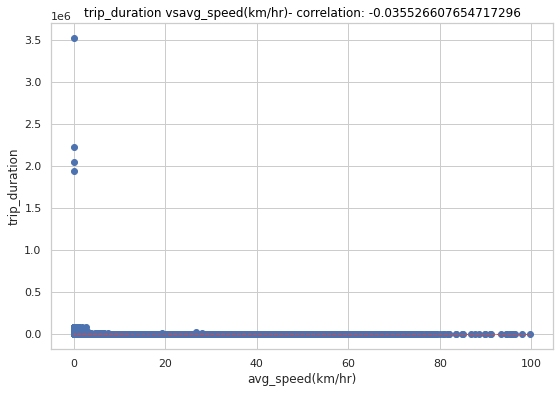

In [32]:
fig = plt.figure(figsize=(9, 6))
ax = fig.gca()
feature = taxi_data['avg_speed(km/hr)']
label = taxi_data['trip_duration']
correlation = feature.corr(label)
plt.scatter(x=feature, y=label)
plt.xlabel('avg_speed(km/hr)')
plt.ylabel('trip_duration')
ax.set_title('trip_duration vs' +'avg_speed(km/hr)' + '- correlation: ' + str(correlation))
z = np.polyfit(taxi_data['avg_speed(km/hr)'], taxi_data['trip_duration'], 1)
y_hat = np.poly1d(z)(taxi_data['avg_speed(km/hr)'])
plt.plot(taxi_data['avg_speed(km/hr)'], y_hat, "r--", lw=1)

plt.show()

In [33]:
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,pickup_year,pickup_month,pickup_date,pickup_hour,pickup_minute,pickup_second,pickup_day,avg_speed(km/hr)
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,1.502172,2016,3,14,17,24,55,1,11.89
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,1.808660,2016,6,12,0,43,35,7,9.82
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,6.379687,2016,1,19,11,35,24,4,10.81
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,1.483632,2016,4,6,19,32,31,3,12.45
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,1.187038,2016,3,26,13,30,55,6,9.82


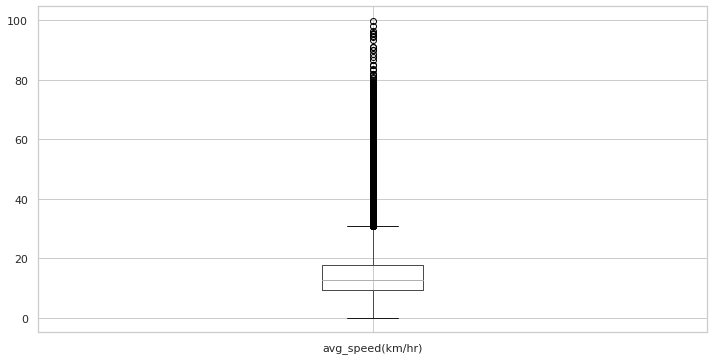

In [34]:
plt.figure(figsize=(12, 6))
taxi_data.boxplot(column='avg_speed(km/hr)')

outlier detection, 

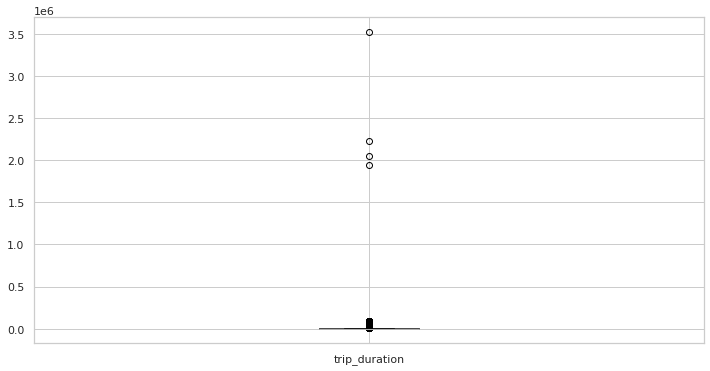

In [35]:
plt.figure(figsize=(12, 6))
taxi_data.boxplot(column='trip_duration')

In trip duration, there are some of the outliers. so we will see which of duration is more than one day. 

In [36]:
# Outliers detection 
taxi_data[taxi_data.trip_duration>86400]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,pickup_year,pickup_month,pickup_date,pickup_hour,pickup_minute,pickup_second,pickup_day,avg_speed(km/hr)
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,0,1939736,20.160235,2016,1,5,0,19,42,4,0.04
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,0,2049578,5.992874,2016,2,13,22,38,0,6,0.01
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,0,2227612,1.633027,2016,1,5,6,14,15,4,0.00
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,0,3526282,19.926608,2016,2,13,22,46,52,6,0.02


we can see some of these duratin are several days , so we use Log transformation of the trip duration results in a normal distribution.

In [37]:
taxi_data.shape

(1453694, 20)

In [38]:
taxi_data= taxi_data[taxi_data.trip_duration < 2100]

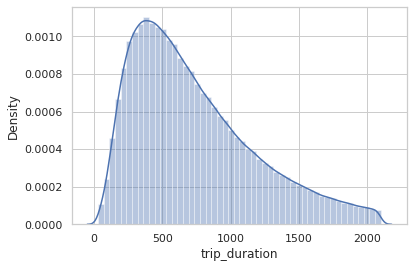

In [39]:
sns.distplot(
    taxi_data['trip_duration']
    )

Text(0.5, 1.0, 'Distribution of trip duration (sec) in Log Scale')

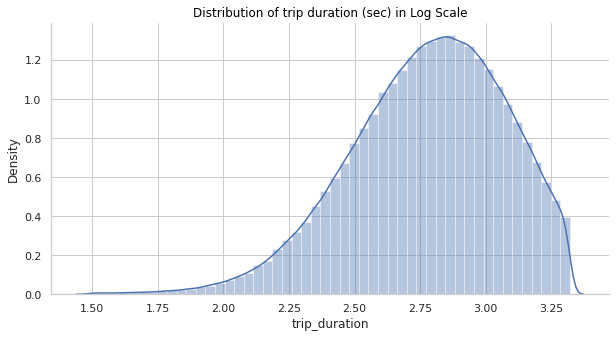

In [40]:
#log transformation
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)
sns.distplot(
    np.log10(taxi_data['trip_duration']))
plt.title("Distribution of trip duration (sec) in Log Scale")

In [41]:
taxi_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,pickup_year,pickup_month,pickup_date,pickup_hour,pickup_minute,pickup_second,pickup_day,avg_speed(km/hr)
count,1.380198e+06,1.380198e+06,1.380198e+06,1.380198e+06,1.380198e+06,1.380198e+06,1.380198e+06,1.380198e+06,1.380198e+06,1380198.0,1.380198e+06,1.380198e+06,1.380198e+06,1.380198e+06,1.380198e+06,1.380198e+06,1.380198e+06
mean,1.534112e+00,1.662094e+00,-7.397684e+01,4.075229e+01,-7.397503e+01,4.075293e+01,5.052174e-03,7.349756e+02,2.922478e+00,2016.0,3.499887e+00,1.549154e+01,1.358348e+01,2.962003e+01,2.947614e+01,4.337883e+00,1.425917e+01
std,4.988352e-01,1.313631e+00,6.760336e-02,2.785206e-02,6.782607e-02,3.203492e-02,7.089889e-02,4.478196e+02,2.890197e+00,0.0,1.679746e+00,8.711154e+00,6.457995e+00,1.732192e+01,1.731772e+01,1.781803e+00,7.630394e+00
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.435970e+01,0.000000e+00,3.100000e+01,0.000000e+00,2016.0,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399203e+01,4.073822e+01,-7.399140e+01,4.073711e+01,0.000000e+00,3.870000e+02,1.206012e+00,2016.0,2.000000e+00,8.000000e+00,9.000000e+00,1.500000e+01,1.400000e+01,3.000000e+00,9.110000e+00
50%,2.000000e+00,1.000000e+00,-7.398202e+01,4.075441e+01,-7.398000e+01,4.075487e+01,0.000000e+00,6.340000e+02,2.000765e+00,2016.0,3.000000e+00,1.500000e+01,1.400000e+01,3.000000e+01,2.900000e+01,4.000000e+00,1.269000e+01
75%,2.000000e+00,2.000000e+00,-7.396848e+01,4.076830e+01,-7.396394e+01,4.077009e+01,0.000000e+00,9.940000e+02,3.497294e+00,2016.0,5.000000e+00,2.300000e+01,1.900000e+01,4.500000e+01,4.400000e+01,6.000000e+00,1.760000e+01
max,2.000000e+00,9.000000e+00,-6.133553e+01,4.391176e+01,-6.133553e+01,4.391176e+01,1.000000e+00,2.099000e+03,4.338242e+01,2016.0,6.000000e+00,3.100000e+01,2.300000e+01,5.900000e+01,5.900000e+01,7.000000e+00,9.978000e+01


In [42]:
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,pickup_year,pickup_month,pickup_date,pickup_hour,pickup_minute,pickup_second,pickup_day,avg_speed(km/hr)
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,1.502172,2016,3,14,17,24,55,1,11.89
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,1.808660,2016,6,12,0,43,35,7,9.82
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,1.483632,2016,4,6,19,32,31,3,12.45
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,1.187038,2016,3,26,13,30,55,6,9.82
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,0,443,1.099625,2016,1,30,22,1,40,6,8.94


In [43]:
taxi_data['pickup_longitude']= round(taxi_data['pickup_longitude'],3)
taxi_data['pickup_latitude']= round(taxi_data['pickup_latitude'],3)
taxi_data['dropoff_longitude']= round(taxi_data['dropoff_longitude'],3)
taxi_data['dropoff_latitude']= round(taxi_data['dropoff_latitude'],3)


In [44]:
col_to_drop= ['id','pickup_year','avg_speed(km/hr)',
                          'pickup_datetime','dropoff_datetime']
taxi_df= taxi_data.drop(col_to_drop, axis=1)

In [45]:
taxi_df = pd.get_dummies(taxi_df, columns=["pickup_day", "pickup_hour"], prefix=["day", "hour"])

In [46]:
taxi_df.shape

(1380198, 43)

In [47]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1380198 entries, 0 to 1458643
Data columns (total 43 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1380198 non-null  int64  
 1   passenger_count     1380198 non-null  int64  
 2   pickup_longitude    1380198 non-null  float64
 3   pickup_latitude     1380198 non-null  float64
 4   dropoff_longitude   1380198 non-null  float64
 5   dropoff_latitude    1380198 non-null  float64
 6   store_and_fwd_flag  1380198 non-null  int64  
 7   trip_duration       1380198 non-null  int64  
 8   distance            1380198 non-null  float64
 9   pickup_month        1380198 non-null  int64  
 10  pickup_date         1380198 non-null  int64  
 11  pickup_minute       1380198 non-null  int64  
 12  pickup_second       1380198 non-null  int64  
 13  day_1               1380198 non-null  uint8  
 14  day_3               1380198 non-null  uint8  
 15  day_4          

In [48]:
taxi_df.corr()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,pickup_month,pickup_date,pickup_minute,pickup_second,day_1,day_3,day_4,day_5,day_6,day_7,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
vendor_id,1.000000,0.290229,0.005148,0.005864,0.001857,0.005185,-0.076298,0.003247,0.004124,-0.006564,0.000203,-0.000084,0.000820,-0.000819,-0.001252,0.000262,-0.001292,0.000246,0.002832,0.001729,-0.001331,-0.005720,-0.008192,-0.006747,-0.008140,-0.007001,-0.001859,0.000343,0.002193,0.004233,0.004116,0.001174,-0.002999,-0.004279,-0.005441,-0.001821,0.002481,0.005460,0.003264,0.002840,0.003538,0.002991,0.001545
passenger_count,0.290229,1.000000,-0.000472,-0.002555,-0.000926,-0.001283,-0.021726,0.010640,0.005149,-0.003009,0.001870,0.000952,0.000861,-0.008987,-0.009735,-0.014122,-0.000871,0.021064,0.016106,0.004201,0.006091,0.004511,0.003963,0.003541,-0.006499,-0.014921,-0.013364,-0.009917,-0.006860,-0.001570,-0.000021,0.000045,0.000872,0.002706,0.001420,0.002066,0.000103,0.000155,0.000289,0.001872,0.004899,0.006816,0.005867
pickup_longitude,0.005148,-0.000472,1.000000,0.159171,0.883353,0.135606,0.004711,0.066897,0.162174,-0.002005,-0.002699,-0.001782,0.001056,0.012471,-0.001799,0.000992,-0.003281,-0.011422,0.003818,0.001117,-0.007553,-0.012950,-0.011847,-0.003064,0.007818,0.005613,0.007025,0.002059,0.000297,0.003028,0.001266,0.000276,-0.001816,0.001021,0.001224,0.002687,0.000645,-0.005362,-0.003069,0.001043,0.000271,-0.000403,0.005539
pickup_latitude,0.005864,-0.002555,0.159171,1.000000,0.145937,0.590254,-0.002330,-0.111055,-0.164182,0.002702,-0.006024,0.000098,0.000572,0.010601,0.015301,0.020406,0.004349,-0.030200,-0.025697,-0.060940,-0.060953,-0.054408,-0.046284,-0.026984,-0.008034,0.007268,0.030157,0.027139,0.022788,0.027746,0.024973,0.025829,0.023069,0.024181,0.028305,0.025405,0.026970,0.017786,0.003133,-0.015744,-0.023479,-0.033653,-0.050641
dropoff_longitude,0.001857,-0.000926,0.883353,0.145937,1.000000,0.203003,0.003451,0.071198,0.161329,0.002206,-0.001729,-0.001875,0.000207,0.005007,-0.002835,-0.001965,-0.000976,-0.006319,0.008285,0.010485,0.012054,0.010892,0.015174,0.028518,0.028512,0.014738,0.004988,-0.004779,-0.009581,-0.005959,-0.005741,-0.004818,-0.007356,-0.004352,-0.003699,-0.002321,-0.005879,-0.011073,-0.009414,-0.004912,-0.001145,0.001045,0.006179
dropoff_latitude,0.005185,-0.001283,0.135606,0.590254,0.203003,1.000000,-0.005300,-0.113432,-0.075816,0.003370,-0.004710,-0.000042,0.001260,0.008452,0.011213,0.013488,0.001066,-0.023620,-0.013766,-0.035290,-0.032302,-0.030781,-0.026362,-0.022060,-0.015393,0.004249,0.019025,0.009382,0.002648,0.011720,0.011280,0.013856,0.014067,0.018755,0.024755,0.022699,0.022125,0.012038,0.000084,-0.009696,-0.012388,-0.018613,-0.030016
store_and_fwd_flag,-0.076298,-0.021726,0.004711,-0.002330,0.003451,-0.005300,1.000000,0.013592,0.015573,-0.000674,0.000985,-0.000030,0.001385,0.001792,0.000559,0.001027,0.001028,-0.001938,-0.002717,-0.001750,-0.000510,-0.000400,-0.000035,-0.000372,-0.000788,-0.002340,-0.003516,-0.001150,-0.000703,-0.000755,0.000777,0.001206,0.001823,0.002507,0.001768,0.002831,0.002442,0.000231,0.001053,-0.001296,-0.003123,-0.000212,0.000510
trip_duration,0.003247,0.010640,0.066897,-0.111055,0.071198,-0.113432,0.013592,1.000000,0.686069,0.039917,0.009584,-0.009351,0.000420,-0.023074,0.023202,0.034213,0.015393,-0.019074,-0.042399,-0.000166,-0.011799,-0.018118,-0.014652,-0.005826,-0.016655,-0.053839,-0.035983,-0.001242,0.007965,0.009007,0.018231,0.019046,0.017837,0.019088,0.013616,0.002852,0.008148,0.007559,-0.007905,-0.012808,-0.006039,0.006815,0.009632
distance,0.004124,0.005149,0.162174,-0.164182,0.161329,-0.075816,0.015573,0.686069,1.000000,-0.002391,0.004203,-0.007127,0.001151,0.010603,-0.019041,-0.023246,-0.012679,0.005066,0.047777,0.058857,0.050910,0.040087,0.046002,0

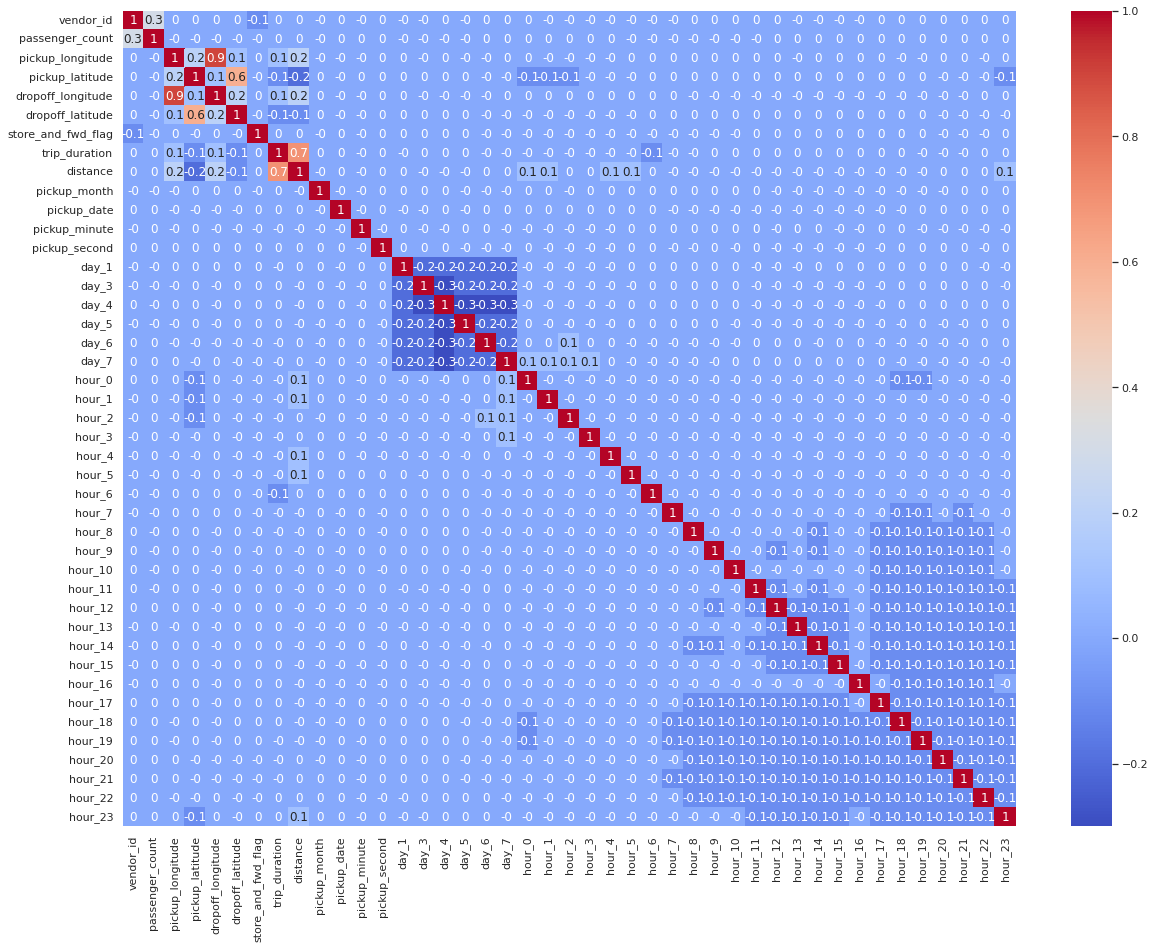

In [49]:
plt.figure(figsize=(20,15))
sns.heatmap(round(taxi_df.corr(),1),annot=True,cmap='coolwarm')

In [50]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [51]:
from scipy.stats import zscore

In [52]:
X= taxi_df.drop(['trip_duration'],axis=1)
y= (taxi_df['trip_duration'])

In [53]:
X.apply(zscore)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,distance,pickup_month,pickup_date,pickup_minute,pickup_second,day_1,day_3,day_4,day_5,day_6,day_7,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0.933953,-0.504018,-0.076373,0.563910,0.147901,0.408028,-0.071259,-0.491422,-0.297597,-0.171222,-0.324446,1.473859,2.602163,-0.408418,-0.633630,-0.424067,-0.426560,-0.395942,-0.196988,-0.167424,-0.142336,-0.122694,-0.106242,-0.102745,-0.153401,-0.199989,-0.219888,-0.220922,-0.216895,-0.221445,-0.22694,-0.225263,-0.227437,-0.222299,-0.209237,4.326849,-0.256537,-0.258886,-0.249885,-0.250257,-0.243988,-0.226145
1,-1.070718,-0.504018,-0.046787,-0.477291,-0.353380,-0.684489,-0.071259,-0.385378,1.488388,-0.400812,0.772430,0.318972,-0.384296,-0.408418,-0.633630,-0.424067,-0.426560,2.525622,5.076449,-0.167424,-0.142336,-0.122694,-0.106242,-0.102745,-0.153401,-0.199989,-0.219888,-0.220922,-0.216895,-0.221445,-0.22694,-0.225263,-0.227437,-0.222299,-0.209237,-0.231115,-0.256537,-0.258886,-0.249885,-0.250257,-0.243988,-0.226145
3,0.933953,-0.504018,-0.490567,-1.159457,-0.545046,-1.433643,-0.071259,-0.497837,0.297731,-1.089585,0.137396,0.087994,-0.384296,2.448469,-0.633630,-0.424067,-0.426560,-0.395942,-0.196988,-0.167424,-0.142336,-0.122694,-0.106242,-0.102745,-0.153401,-0.199989,-0.219888,-0.220922,-0.216895,-0.221445,-0.22694,-0.225263,-0.227437,-0.222299,-0.209237,-0.231115,-0.256537,3.862709,-0.249885,-0.250257,-0.243988,-0.226145
4,0.933953,-0.504018,0.056761,1.461498,0.029953,0.938680,-0.071259,-0.600458,-0.297597,1.206323,0.021936,1.473859,-0.384296,-0.408418,-0.633630,-0.424067,2.344335,-0.395942,-0.196988,-0.167424,-0.142336,-0.122694,-0.106242,-0.102745,-0.153401,-0.199989,-0.219888,-0.220922,-0.216895,-0.221445,-0.22694,4.439246,-0.227437,-0.222299,-0.209237,-0.231115,-0.256537,-0.258886,-0.249885,-0.250257,-0.243988,-0.226145
5,0.933953,3.302226,-0.091165,-0.369580,-0.250175,-0.122623,-0.071259,-0.630702,-1.488254,1.665505,-1.652244,0.607694,-0.384296,-0.408418,-0.633630,-0.424067,2.344335,-0.395942,-0.196988,-0.167424,-0.142336,-0.122694,-0.106242,-0.102745,-0.153401,-0.199989,-0.219888,-0.220922,-0.216895,-0.221445,-0.22694,-0.225263,-0.227437,-0.222299,-0.209237,-0.231115,-0.256537,-0.258886,-0.249885,-0.250257,4.098562,-0.226145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,0.933953,1.779728,-0.076373,-0.225966,-0.294406,-0.403556,-0.071259,-0.586600,0.297731,-0.859994,0.079666,-1.471103,-0.384296,-0.408418,-0.633630,2.358118,-0.426560,-0.395942,-0.196988,-0.167424,-0.142336,-0.122694,-0.106242,-0.102745,-0.153401,-0.199989,-0.219888,-0.220922,-0.216895,-0.221445,-0.22694,4.439246,-0.227437,-0.222299,-0.209237,-0.231115,-0.256537,-0.258886,-0.249885,-0.250257,-0.243988,-0.226145
1458640,-1.070718,-0.504018,-0.357433,-0.190063,0.074183,1.375686,-0.071259,1.080804,-1.488254,-0.630403,0.310587,-0.835915,-0.384296,-0.408418,-0.633630,-0.424067,-0.426560,2.525622,-0.196988,-0.167424,-0.142336,-0.122694,-0.106242,-0.102745,-0.153401,5.000271,-0.219888,-0.220922,-0.216895,-0.221445,-0.22694,-0.225263,-0.227437,-0.222299,-0.209237,-0.231115,-0.256537,-0.258886,-0.249885,-0.250257,-0.243988,-0.226145
1458641,0.933953,-0.504018,0.263858,0.599814,-0.427098,-1.433643,-0.071259,1.695060,0.297731,0.747142,1.580655,0.665438,-0.384296,-0.408418,-0.633630,2.358118,-0.426560,-0.395942,-0.196988,-0.167424,-0.142336,-0.122694,-0.106242,-0.102745,6.518854,-0.199989,-0.219888,-0.220922,-0.216895,-0.221445,-0.22694,-0.225263,-0.227437,-0.222299,-0.209237,-0.231115,-0.256537,-0.258886,-0.249885,-0.250257,-0.243988,-0.226145
1458642,-1.070718,-0.504018,-0.076373,-0.118256,0.000466,0.127095,-0.071259,-0.633159,-1.488254,-1.20438

In [54]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 32)

In [55]:
scale = MinMaxScaler()
X_train= scale.fit_transform(X_train)
x_test= scale.transform(X_test)

In [56]:
scale_ = StandardScaler()
X_train= scale_.fit_transform(X_train)
x_test= scale_.transform(X_test)

In [55]:
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [56]:
train_pred= reg.predict(X_train)

In [57]:
test_pred= reg.predict(X_test)

In [58]:
mean_squared_error((y_test), (test_pred))

94569.31928831115

In [59]:
mean_squared_error((y_train), (train_pred))

94416.6224510943

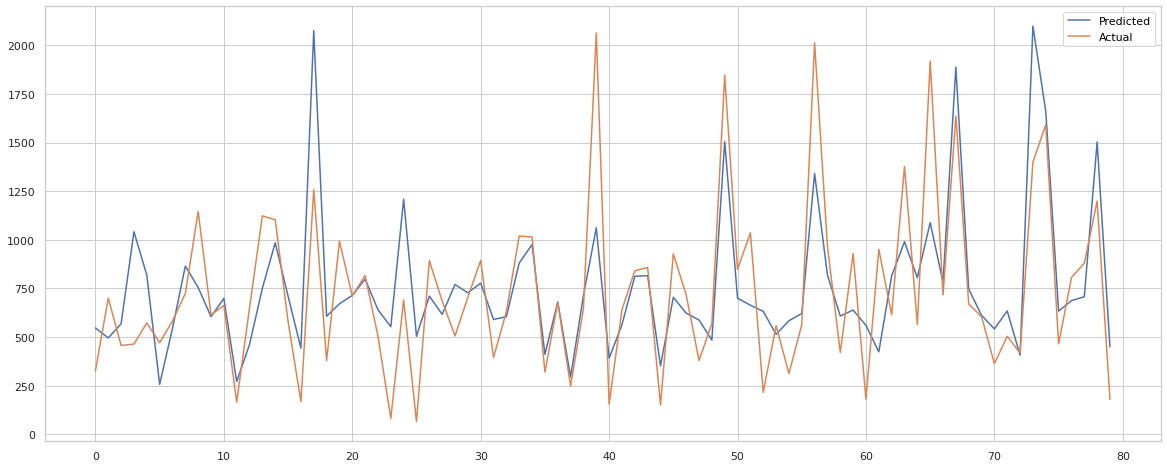

In [60]:
plt.figure(figsize=(20,8))
plt.plot((test_pred[20:100]))
plt.plot(np.array((y_test[20:100])))
plt.legend(["Predicted","Actual"])
plt.show()

In [61]:
reg.score(X_train, y_train)

0.5294843800309825

In [62]:
r2_score((y_test), (test_pred))

0.5272610122910633

In [65]:
r2_score((10**(y_test)) , (10**(test_pred)))

-2.4301306764895614e-05

In [66]:
r2_score((10**(y_test[180000:200000])) , (10**(test_pred[180000:200000])))

-1.0408382777438163e-05

In [67]:
10**(y_test[100000:200000])

913696     0
1328064    0
350427     0
1261315    0
1417206    0
          ..
1374007    0
1230319    0
617573     0
642377     0
284599     0
Name: trip_duration, Length: 100000, dtype: int64

In [68]:
10**(test_pred[171840:171850])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [66]:
1-((1- r2_score((y_test), (test_pred)))*(X_test.shape[0] - 1)/(X_test.shape[0] - X_test.shape[1] - 1))

0.5271890729675062

In [70]:
mean_absolute_error(10**(y_test), 10**(test_pred))

1.4749178170546168e+16

In [63]:
reg.intercept_

-3264.7716651292635

In [64]:
reg.coef_

array([-3.09750164e+00,  3.24662783e+00, -8.30212826e+02,  8.67810580e+02,
        4.54352929e+02, -1.46227804e+03,  3.37176898e+00,  1.14399772e+02,
        1.18112040e+01,  4.46182700e-01, -1.11498728e-01,  2.49565014e-03,
       -3.45996624e+01,  4.40293451e+01,  3.93847712e+01,  3.82291963e+01,
       -1.26268182e+01, -7.44168320e+01, -5.71453498e+01, -8.61320467e+01,
       -1.03120253e+02, -1.30455333e+02, -1.99266252e+02, -2.89746255e+02,
       -2.01972285e+02, -4.97765431e+01,  6.35958632e+01,  9.02011217e+01,
        9.39293911e+01,  1.12066602e+02,  1.19638552e+02,  1.14694346e+02,
        1.25211459e+02,  1.25069746e+02,  1.04319881e+02,  1.10619416e+02,
        9.84535016e+01,  4.49125652e+01, -7.14846704e+00, -2.07818064e+01,
       -1.57271322e+01, -4.14407204e+01])

In [65]:
from sklearn.linear_model import Lasso
lasso  = Lasso(alpha=0.0001 , max_iter= 3000)

lasso.fit(X_train, y_train)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=3000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
lasso.score(X_train, y_train,,,)

In [66]:
### Cross validation
from sklearn.model_selection import GridSearchCV
lasso = Lasso()
parameters = {'alpha': [1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=10)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20, 30,
                                   40, 45, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [67]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1}

Using  {'alpha': 1}  the negative mean squared error is:  -97256.31972472831


In [68]:
y_pred_lasso = lasso_regressor.predict(X_test)

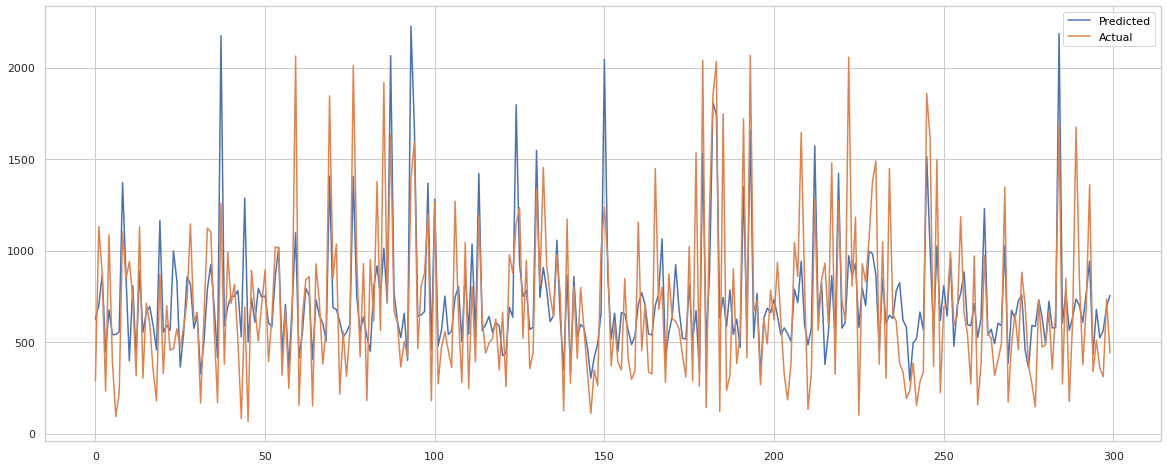

In [69]:
plt.figure(figsize=(20,8))
plt.plot((y_pred_lasso)[:300])
plt.plot((np.array(y_test)[:300]))
plt.legend(["Predicted","Actual"])
plt.show()

In [ ]:
MSE  = mean_squared_error(10**(y_test), 10**(y_pred_lasso))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(10**(y_test), 10**(y_pred_lasso))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(10**(y_test), 10**(y_pred_lasso)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
ridge = Ridge()
parameters_2 = {'alpha': [1e-4,1e-3,1e-2,1,5,10,20,50,80,100,150,200,500,1000,1200,1260]}
ridge_regressor = GridSearchCV(ridge, parameters_2, scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 1, 5, 10, 20, 50, 80,
                                   100, 150, 200, 500, 1000, 1200, 1260]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [71]:
print("The best fit alpha value is found out to be :" ,ridge_regressor.best_params_)
print("\nUsing ",ridge_regressor.best_params_, " the negative mean squared error is: ", ridge_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1260}

Using  {'alpha': 1260}  the negative mean squared error is:  -96358.7424525


In [72]:
y_pred_ridge = ridge_regressor.predict(X_test)

In [ ]:
MSE  = mean_squared_error(10**(y_test), 10**(y_pred_ridge))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score((y_test), (y_pred_ridge))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(10**(y_test), 10**(y_pred_ridge)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

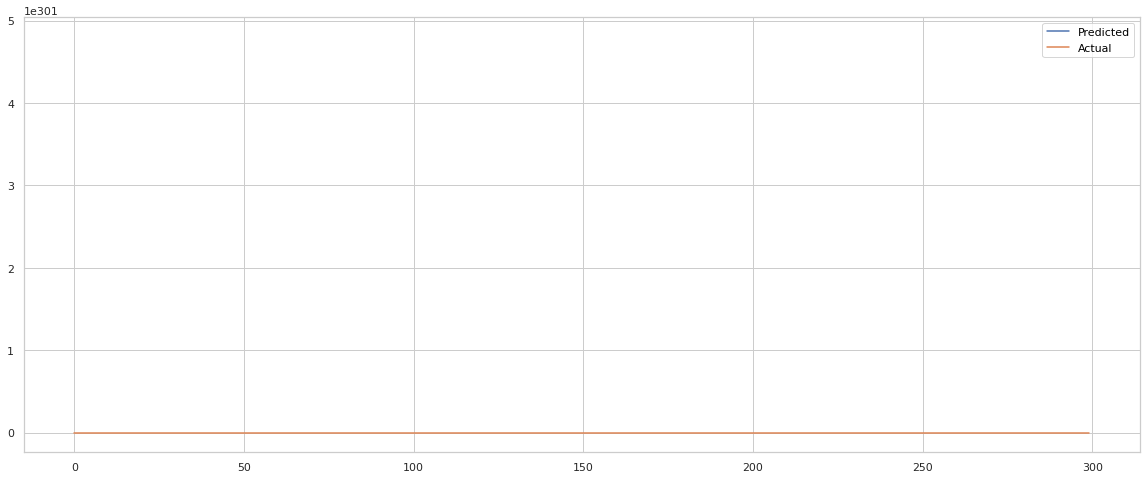

In [73]:
plt.figure(figsize=(20,8))
plt.plot(10**(y_pred_ridge )[:300])
plt.plot(10**(np.array(y_test))[:300])
plt.legend(["Predicted","Actual"])
plt.show()

In [74]:
from sklearn.linear_model import ElasticNet
#a * L1 + b * L2
#alpha = a + b and l1_ratio = a / (a + b)
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.4)
elasticnet.fit(X_train,y_train)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.4,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [75]:
elasticnet.score(X_test, y_test)

0.5043943623440301

In [76]:
y_pred_en = elasticnet.predict(X_test)

In [ ]:
MSE  = mean_squared_error(10**(y_test), 10**(y_pred_en))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score((y_test), (y_pred_en))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(10**(y_test), 10**(y_pred_en)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

In [ ]:
elastic = ElasticNet()
parameters_3 = {'alpha': [1e-4,1e-3,1e-2,1e-1,1,3,5],'l1_ratio':[0.1,0.2,0.3]}
elastic_regressor = GridSearchCV(elastic, parameters_3, scoring='neg_mean_squared_error',cv=5)
elastic_regressor.fit(X_train, y_train)

In [ ]:
print("The best fit alpha value is found out to be :" ,elastic_regressor.best_params_)
print("\nUsing ",elastic_regressor.best_params_, " the negative mean squared error is: ", elastic_regressor.best_score_)

In [ ]:
y_pred_elastic = elastic_regressor.predict(X_test)

In [ ]:
MSE  = mean_squared_error(10**(y_test), 10**(y_pred_elastic))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(10**(y_test), 10**(y_pred_elastic))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(10**(y_test), 10**(y_pred_elastic)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(10**(y_pred_elastic)[:100])
plt.plot(10**(np.array(y_test))[:100])
plt.legend(["Predicted","Actual"])
plt.show()

In [ ]:
from xgboost import XGBRegressor
xgb= XGBRegressor()
grid_values= {'n_estimators':[100], 'max_depth':[6,7], 'eta':[0.01], 'colsample_bytree':[0.8]}
Regressor = GridSearchCV(xgb, param_grid = grid_values, scoring = 'neg_mean_squared_error', cv=3)
Regressor.fit(X_train, y_train)

In [ ]:
x= Regressor.best_estimator_

In [ ]:
y_pred_xg= x.predict(X_test)
r2_score((y_test),(y_pred_xg))

In [ ]:
y_pred_xgb= Regressor.predict(X_test)
r2_score(10**(y_test),10**(y_pred_xgb),multioutput='variance_weighted')


In [ ]:
1-(1- r2_score(10**(y_test),10**(y_pred_xg)))*(X_test.shape[0] - 1)/(X_test.shape[0] - X_test.shape[1] - 1)

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(10**(y_pred_xgb)[4770:4800])
plt.plot(10**(np.array(y_test))[4770:4800])
plt.legend(["Predicted","Actual"])
plt.show()

In [ ]:
print("The best fit values is found out to be :" ,Regressor.best_params_)


In [ ]:
mean_squared_error(10**(y_test), 10**(y_pred_xgb))

In [ ]:
xgb.fit(X_train, y_train)

In [ ]:
y_pred_x= xgb.predict(X_test)

In [ ]:
xgb.score(X_test,y_test)

In [ ]:
r2_score(10**(y_test),10**(y_pred_x))

In [ ]:
from xgboost import plot_tree
_, ax = plt.subplots(figsize=(20,8)) # Resize figure
plot_tree(xgb,rankdir='LR',ax=ax)
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

histogram_gradient_boosting = HistGradientBoostingRegressor()
'''grids= {'n_estimators':[100], 'max_depth':[3, 5, 7],'learning_rate':[20,10,5,1,0.1,0.01,0.001]}

cv_results_hgbdt = GridSearchCV(histogram_gradient_boosting,grids,cv=3)'''
histogram_gradient_boosting.fit(X_train,y_train)

In [ ]:
y_pred_gbr= histogram_gradient_boosting.predict(X_test)

In [ ]:
histogram_gradient_boosting.score(X_test,y_test)

In [ ]:
mean_squared_error(10**(y_test), 10**(y_pred_gbr))

In [ ]:
mean_absolute_error(10**(y_test), 10**(y_pred_gbr))

In [ ]:
from sklearn.ensemble import RandomForestRegressor

RandomForestRegressor is not good choie for regression because it bound the limit of predicted value. 


In [ ]:
RF_reg= RandomForestRegressor(n_estimators=50, random_state=42)
RF_reg.fit(X_train,y_train)

In [ ]:
y_pred_rf= RF_reg.predict(X_test)

In [ ]:
RF_reg.score(X_test,y_test)